In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from SALib.sample import saltelli
from SALib.analyze import sobol
from sklearn.metrics import make_scorer
import joblib

In [2]:
# Load the dataset
data = pd.read_csv('heart.csv')

# Display the first few rows of the dataset
data.head()

# Check for missing values
print("Missing values:\n", data.isnull().sum())

# Check data types
print("\nData types:\n", data.dtypes)
# Separate features and target variable
X = data.drop(columns=['heart_attack'])
y = data['heart_attack']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Missing values:
 age                  0
sex                  0
total_cholesterol    0
ldl                  0
hdl                  0
systolic_bp          0
diastolic_bp         0
smoking              0
diabetes             0
heart_attack         0
dtype: int64

Data types:
 age                    int64
sex                    int64
total_cholesterol    float64
ldl                  float64
hdl                  float64
systolic_bp          float64
diastolic_bp         float64
smoking                int64
diabetes               int64
heart_attack           int64
dtype: object


In [3]:
# Define the preprocessing steps
numeric_features = ['age', 'total_cholesterol', 'ldl', 'hdl', 'systolic_bp', 'diastolic_bp']
categorical_features = ['sex', 'smoking', 'diabetes']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Fit and transform the training data
X_train_preprocessed = preprocessor.fit_transform(X_train)

# Transform the test data
X_test_preprocessed = preprocessor.transform(X_test)

# Get the feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()

In [4]:
# Convert the preprocessed data back to a DataFrame for easier inspection
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=feature_names)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=feature_names)

# Display the first few rows of the preprocessed DataFrame
X_train_preprocessed_df.head()

# Calculate VIF for each feature
X_train_sm = sm.add_constant(X_train_preprocessed)
vif_data = pd.DataFrame()
vif_data['Feature'] = ['const'] + list(feature_names)
vif_data['VIF'] = [variance_inflation_factor(X_train_sm, i) for i in range(X_train_sm.shape[1])]
# Display VIF
print("\nVIF:\n", vif_data)

# Identify features with VIF > 10
high_vif_features = vif_data[vif_data['VIF'] > 10]['Feature'].tolist()
print("\nFeatures with VIF > 10:\n", high_vif_features)

# Remove features with VIF > 10
if high_vif_features:
    X_train_preprocessed_df = X_train_preprocessed_df.drop(columns=high_vif_features)
    X_test_preprocessed_df = X_test_preprocessed_df.drop(columns=high_vif_features)
    feature_names = X_train_preprocessed_df.columns



VIF:
                   Feature       VIF
0                   const  2.455059
1                num__age  1.246713
2  num__total_cholesterol  2.835450
3                num__ldl  3.616593
4                num__hdl  1.565803
5        num__systolic_bp  3.415744
6       num__diastolic_bp  3.029160
7              cat__sex_1  1.034092
8          cat__smoking_1  1.049378
9         cat__diabetes_1  1.022640

Features with VIF > 10:
 []


In [5]:
# Recalculate VIF after removing high VIF features
X_train_sm = sm.add_constant(X_train_preprocessed_df)
vif_data = pd.DataFrame()
vif_data['Feature'] = ['const'] + list(feature_names)
vif_data['VIF'] = [variance_inflation_factor(X_train_sm, i) for i in range(X_train_sm.shape[1])]

# Display VIF after removal
print("\nVIF after removal:\n", vif_data)

# Define custom scorers for accuracy, precision, recall, and F1-score
def accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)
scoring = {
    'accuracy': make_scorer(accuracy),
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}


VIF after removal:
                   Feature       VIF
0                   const  2.455059
1                num__age  1.246713
2  num__total_cholesterol  2.835450
3                num__ldl  3.616593
4                num__hdl  1.565803
5        num__systolic_bp  3.415744
6       num__diastolic_bp  3.029160
7              cat__sex_1  1.034092
8          cat__smoking_1  1.049378
9         cat__diabetes_1  1.022640


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Best Cross-Validated Accuracy for Random Forest: 0.9100137985412969
Best Random Forest Accuracy: 0.915
Best Random Forest Precision: 0.5
Best Random Forest Recall: 0.17647058823529413
Best Random Forest F1 Score: 0.2608695652173913

Permutation Importances for Random Forest:
                   Feature  Importance
8         cat__diabetes_1    0.010667
7          cat__smoking_1    0.007500
6              cat__sex_1    0.002833
5       num__diastolic_bp    0.002333
3                num__hdl   -0.002000
0                num__age   -0.003500
1  num__total_cholesterol   -0.004500
4        num__systolic_bp   -0.004500
2                num__ldl   -0.006500


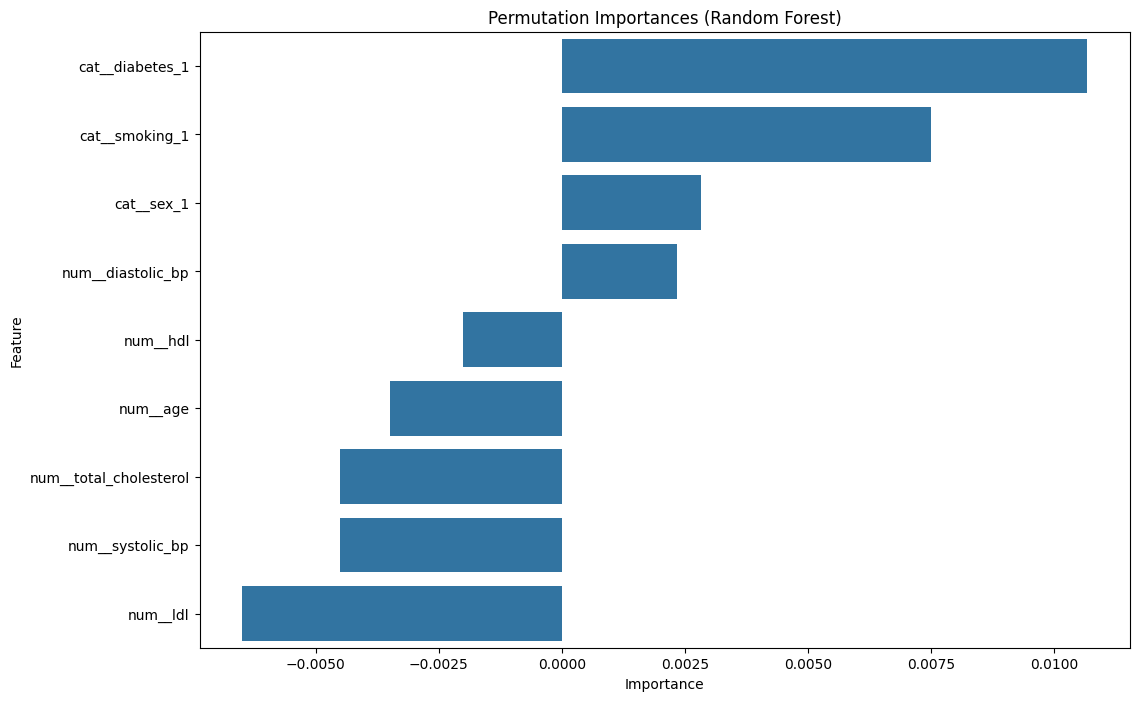


Sobol Indices for Random Forest:
                   Feature        S1  S2
8         cat__diabetes_1  0.185538 NaN
1  num__total_cholesterol  0.106270 NaN
3                num__hdl  0.064516 NaN
7          cat__smoking_1  0.050511 NaN
4        num__systolic_bp  0.043752 NaN
0                num__age  0.022259 NaN
5       num__diastolic_bp  0.017011 NaN
2                num__ldl -0.001251 NaN
6              cat__sex_1 -0.004500 NaN


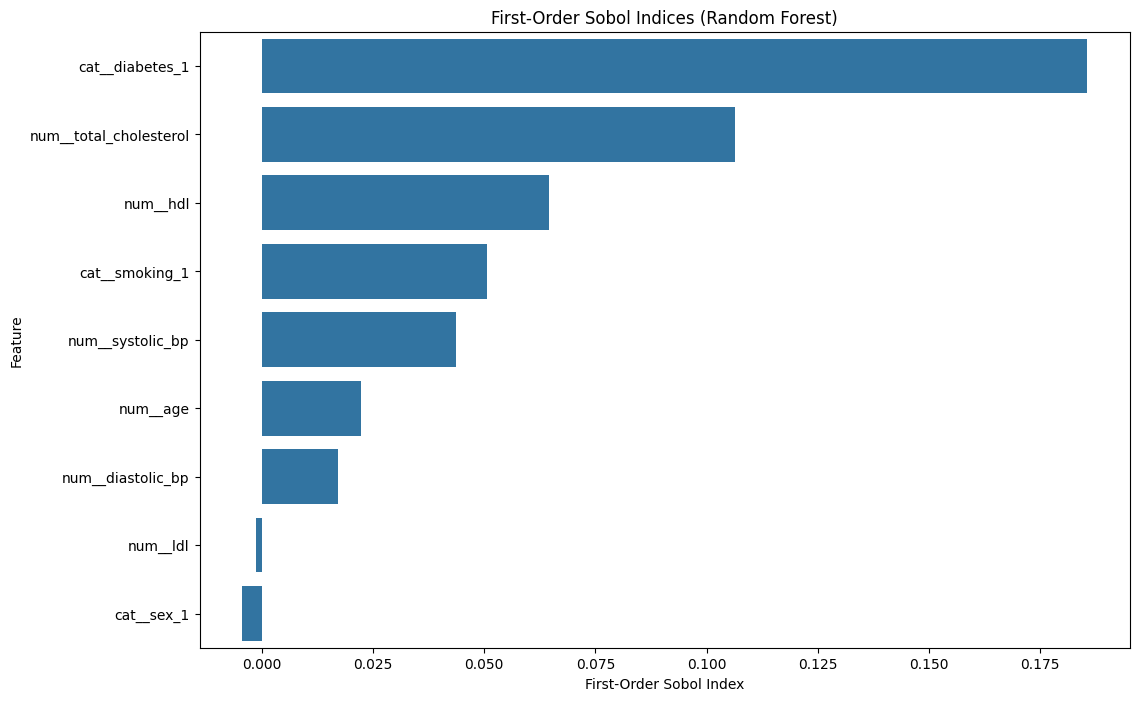

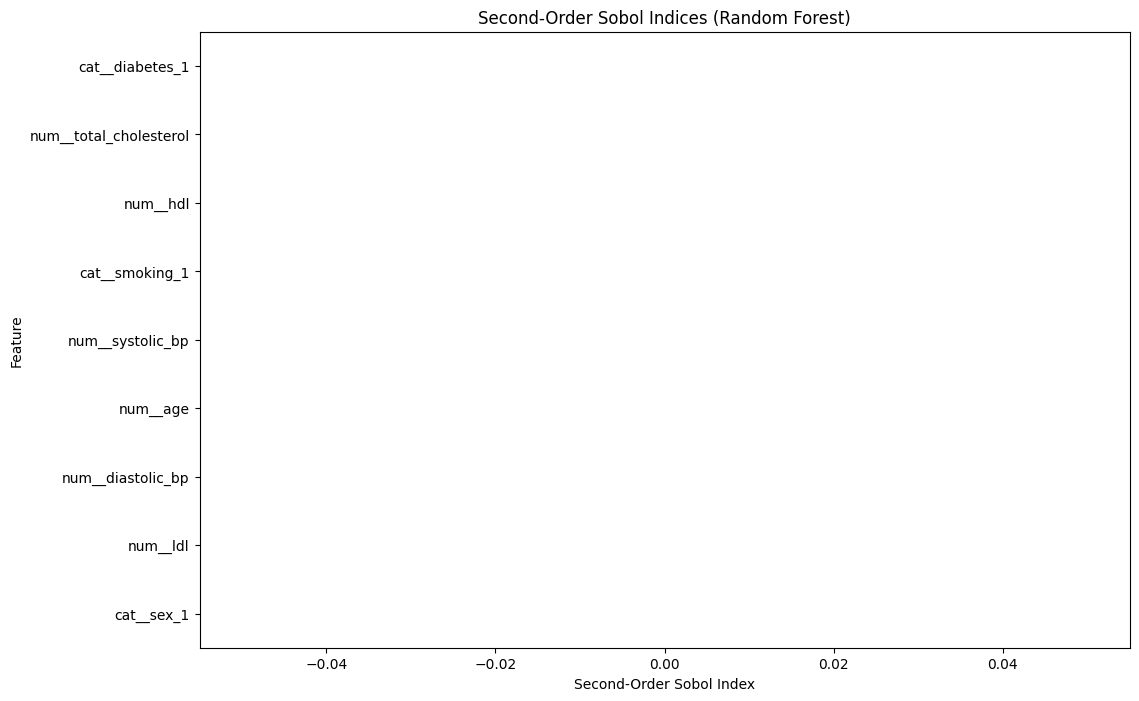

In [6]:
# ### Random Forest Model

# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
# Initialize GridSearchCV for Random Forest
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=3, n_jobs=-1, verbose=2, scoring=scoring, refit='accuracy')

# Fit GridSearchCV for Random Forest
grid_search_rf.fit(X_train_preprocessed_df, y_train)

# Best parameters and best score for Random Forest
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

print(f"Best Parameters for Random Forest: {best_params_rf}")
print(f"Best Cross-Validated Accuracy for Random Forest: {best_score_rf}")

# Use the best model for Random Forest
best_rf_model = grid_search_rf.best_estimator_
# Make predictions with the best Random Forest model
y_pred_best_rf = best_rf_model.predict(X_test_preprocessed_df)

# Evaluate the best Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_best_rf)
precision_rf = precision_score(y_test, y_pred_best_rf)
recall_rf = recall_score(y_test, y_pred_best_rf)
f1_rf = f1_score(y_test, y_pred_best_rf)

print(f"Best Random Forest Accuracy: {accuracy_rf}")
print(f"Best Random Forest Precision: {precision_rf}")
print(f"Best Random Forest Recall: {recall_rf}")
print(f"Best Random Forest F1 Score: {f1_rf}")

# Perform permutation importance for Random Forest
perm_importance_rf = permutation_importance(best_rf_model, X_test_preprocessed_df, y_test, n_repeats=30, random_state=42, n_jobs=-1)

# Create a DataFrame for permutation importances for Random Forest
perm_importance_df_rf = pd.DataFrame({
    'Feature': feature_names,
    'Importance': perm_importance_rf.importances_mean
})

# Sort the DataFrame by importance for Random Forest
perm_importance_df_rf = perm_importance_df_rf.sort_values(by='Importance', ascending=False)

# Display the permutation importances for Random Forest
print("\nPermutation Importances for Random Forest:\n", perm_importance_df_rf)


# Plot permutation importances for Random Forest
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=perm_importance_df_rf)
plt.title('Permutation Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# ### Sobol Sensitivity Analysis for Random Forest

# Define the problem dictionary for Sobol Sensitivity Analysis
problem = {
    'num_vars': len(feature_names),
    'names': feature_names,
    'bounds': [[-3, 3]] * len(feature_names)  # Assuming standardized features
}

# Generate samples for Sobol Sensitivity Analysis
param_values = saltelli.sample(problem, N=1024, calc_second_order=True)

# Predict using the trained Random Forest model
Y_rf = best_rf_model.predict(param_values)

# Perform Sobol Sensitivity Analysis for Random Forest
Si_rf = sobol.analyze(problem, Y_rf, print_to_console=False)

# Create a DataFrame for Sobol indices for Random Forest
sobol_indices_df_rf = pd.DataFrame({
    'Feature': feature_names,
    'S1': Si_rf['S1'],
    'S2': Si_rf['S2'].mean(axis=1)  # Average of second-order indices
})

# Sort the DataFrame by first-order indices for Random Forest
sobol_indices_df_rf = sobol_indices_df_rf.sort_values(by='S1', ascending=False)

# Display the Sobol indices for Random Forest
print("\nSobol Indices for Random Forest:\n", sobol_indices_df_rf)

# Plot first-order Sobol indices for Random Forest
plt.figure(figsize=(12, 8))
sns.barplot(x='S1', y='Feature', data=sobol_indices_df_rf)
plt.title('First-Order Sobol Indices (Random Forest)')
plt.xlabel('First-Order Sobol Index')
plt.ylabel('Feature')
plt.show()

# Plot second-order Sobol indices for Random Forest
plt.figure(figsize=(12, 8))
sns.barplot(x='S2', y='Feature', data=sobol_indices_df_rf)
plt.title('Second-Order Sobol Indices (Random Forest)')
plt.xlabel('Second-Order Sobol Index')
plt.ylabel('Feature')
plt.show()

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters for Logistic Regression: {'C': 10, 'solver': 'liblinear'}
Best Cross-Validated Accuracy for Logistic Regression: 0.9012700290050969
Best Logistic Regression Accuracy: 0.92
Best Logistic Regression Precision: 0.5555555555555556
Best Logistic Regression Recall: 0.29411764705882354
Best Logistic Regression F1 Score: 0.38461538461538464

Permutation Importances for Logistic Regression:
                   Feature  Importance
7          cat__smoking_1    0.013833
8         cat__diabetes_1    0.008833
4        num__systolic_bp    0.008667
1  num__total_cholesterol    0.007667
5       num__diastolic_bp    0.006167
6              cat__sex_1    0.003500
0                num__age    0.002500
3                num__hdl    0.000500
2                num__ldl   -0.001000


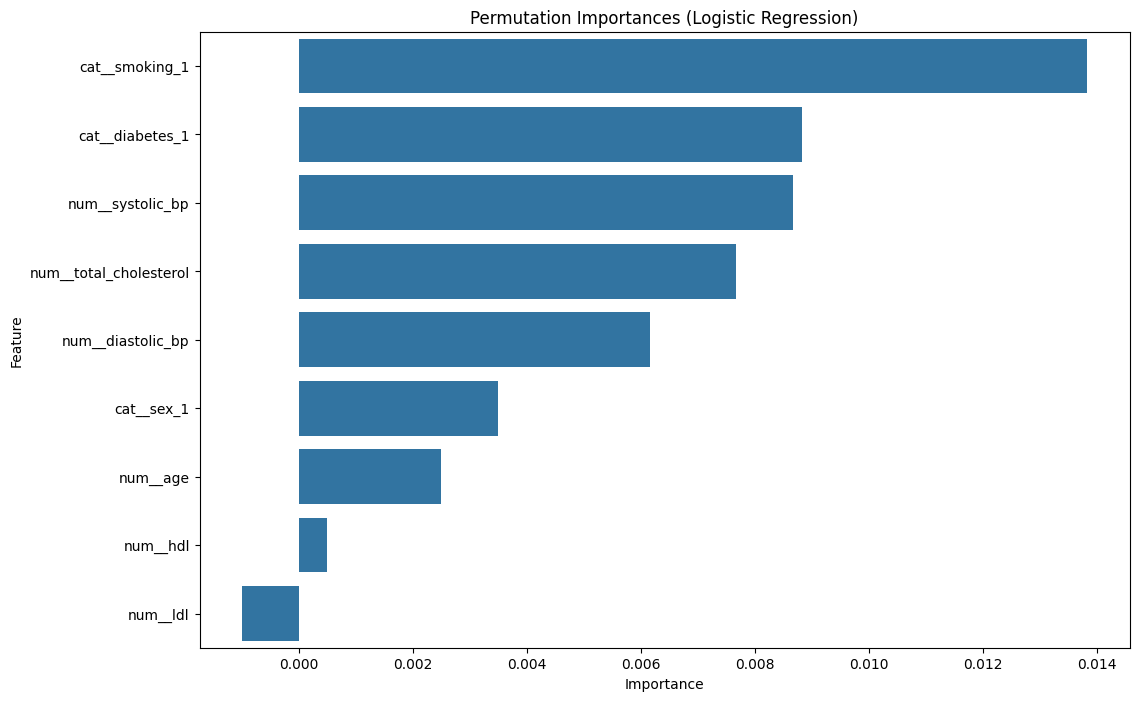


Sobol Indices for Logistic Regression:
                   Feature        S1  S2
8         cat__diabetes_1  0.371599 NaN
7          cat__smoking_1  0.195519 NaN
0                num__age  0.047981 NaN
6              cat__sex_1  0.037626 NaN
3                num__hdl  0.034524 NaN
1  num__total_cholesterol  0.033609 NaN
5       num__diastolic_bp  0.027338 NaN
4        num__systolic_bp  0.021491 NaN
2                num__ldl  0.000000 NaN


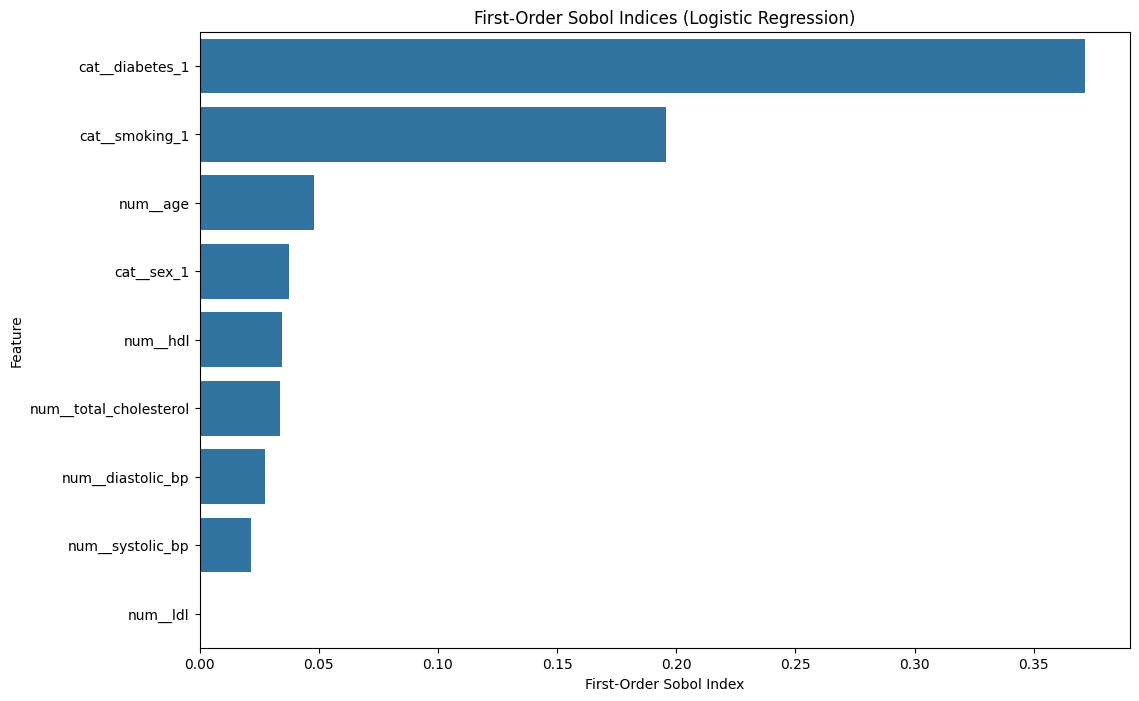

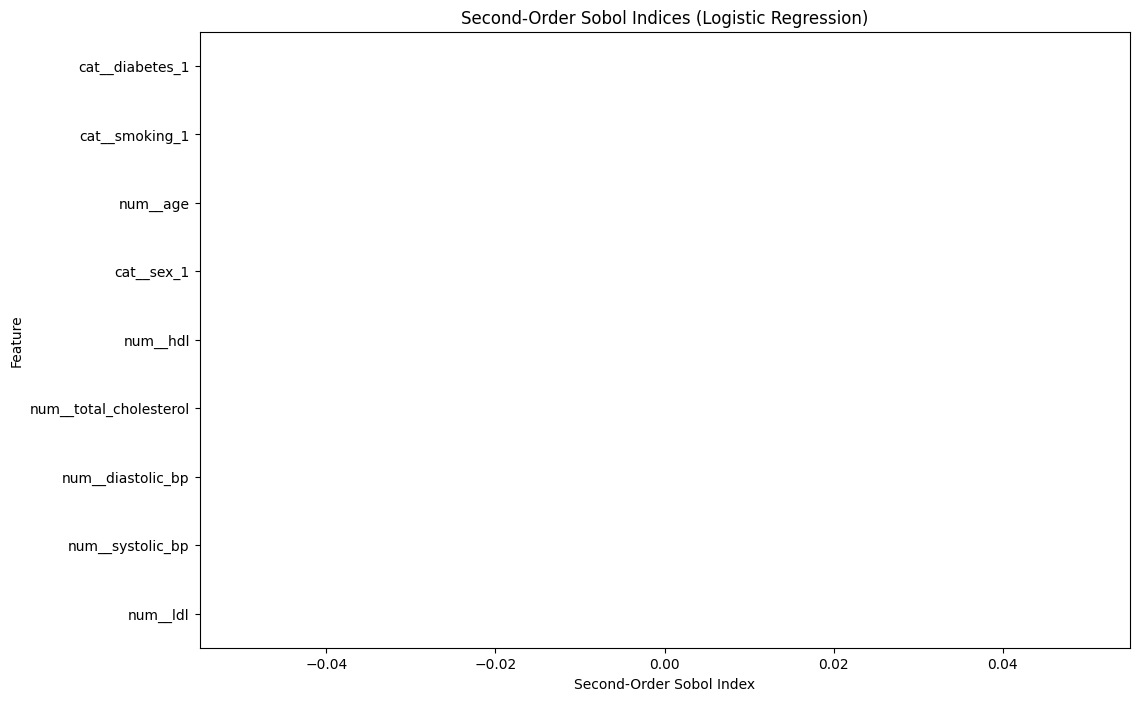

In [7]:
# ### Logistic Regression

# Define the parameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}

# Initialize the Logistic Regression model
lr_model = LogisticRegression(random_state=42, max_iter=1000)
# Initialize GridSearchCV for Logistic Regression
grid_search_lr = GridSearchCV(estimator=lr_model, param_grid=param_grid_lr, cv=3, n_jobs=-1, verbose=2, scoring=scoring, refit='accuracy')

# Fit GridSearchCV for Logistic Regression
grid_search_lr.fit(X_train_preprocessed_df, y_train)

# Best parameters and best score for Logistic Regression
best_params_lr = grid_search_lr.best_params_
best_score_lr = grid_search_lr.best_score_

print(f"Best Parameters for Logistic Regression: {best_params_lr}")
print(f"Best Cross-Validated Accuracy for Logistic Regression: {best_score_lr}")

# Use the best model for Logistic Regression
best_lr_model = grid_search_lr.best_estimator_

# Make predictions with the best Logistic Regression model
y_pred_best_lr = best_lr_model.predict(X_test_preprocessed_df)

# Evaluate the best Logistic Regression model
accuracy_lr = accuracy_score(y_test, y_pred_best_lr)
precision_lr = precision_score(y_test, y_pred_best_lr)
recall_lr = recall_score(y_test, y_pred_best_lr)
f1_lr = f1_score(y_test, y_pred_best_lr)

print(f"Best Logistic Regression Accuracy: {accuracy_lr}")
print(f"Best Logistic Regression Precision: {precision_lr}")
print(f"Best Logistic Regression Recall: {recall_lr}")
print(f"Best Logistic Regression F1 Score: {f1_lr}")

# Perform permutation importance for Logistic Regression
perm_importance_lr = permutation_importance(best_lr_model, X_test_preprocessed_df, y_test, n_repeats=30, random_state=42, n_jobs=-1)

# Create a DataFrame for permutation importances for Logistic Regression
perm_importance_df_lr = pd.DataFrame({
    'Feature': feature_names,
    'Importance': perm_importance_lr.importances_mean
})

# Sort the DataFrame by importance for Logistic Regression
perm_importance_df_lr = perm_importance_df_lr.sort_values(by='Importance', ascending=False)

# Display the permutation importances for Logistic Regression
print("\nPermutation Importances for Logistic Regression:\n", perm_importance_df_lr)

# Plot permutation importances for Logistic Regression
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=perm_importance_df_lr)
plt.title('Permutation Importances (Logistic Regression)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()
# ### Sobol Sensitivity Analysis for Logistic Regression

# Predict using the trained Logistic Regression model
Y_lr = best_lr_model.predict(param_values)

# Perform Sobol Sensitivity Analysis for Logistic Regression
Si_lr = sobol.analyze(problem, Y_lr, print_to_console=False)

# Create a DataFrame for Sobol indices for Logistic Regression
sobol_indices_df_lr = pd.DataFrame({
    'Feature': feature_names,
    'S1': Si_lr['S1'],
    'S2': Si_lr['S2'].mean(axis=1)  # Average of second-order indices
})

# Sort the DataFrame by first-order indices for Logistic Regression
sobol_indices_df_lr = sobol_indices_df_lr.sort_values(by='S1', ascending=False)

# Display the Sobol indices for Logistic Regression
print("\nSobol Indices for Logistic Regression:\n", sobol_indices_df_lr)

# Plot first-order Sobol indices for Logistic Regression
plt.figure(figsize=(12, 8))
sns.barplot(x='S1', y='Feature', data=sobol_indices_df_lr)
plt.title('First-Order Sobol Indices (Logistic Regression)')
plt.xlabel('First-Order Sobol Index')
plt.ylabel('Feature')
plt.show()
# Plot second-order Sobol indices for Logistic Regression
plt.figure(figsize=(12, 8))
sns.barplot(x='S2', y='Feature', data=sobol_indices_df_lr)
plt.title('Second-Order Sobol Indices (Logistic Regression)')
plt.xlabel('Second-Order Sobol Index')
plt.ylabel('Feature')
plt.show()

Fitting 3 folds for each of 120 candidates, totalling 360 fits
Best Parameters for MLP: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant', 'solver': 'sgd'}
Best Cross-Validated Accuracy for MLP: 0.9062637868078435
Best MLP Accuracy: 0.915
Best MLP Precision: 0.5
Best MLP Recall: 0.058823529411764705
Best MLP F1 Score: 0.10526315789473684

Permutation Importances for MLP:
                   Feature  Importance
7          cat__smoking_1    0.012667
0                num__age    0.004333
8         cat__diabetes_1    0.003833
1  num__total_cholesterol    0.002833
3                num__hdl    0.002167
6              cat__sex_1    0.000500
5       num__diastolic_bp    0.000333
2                num__ldl   -0.000667
4        num__systolic_bp   -0.006500


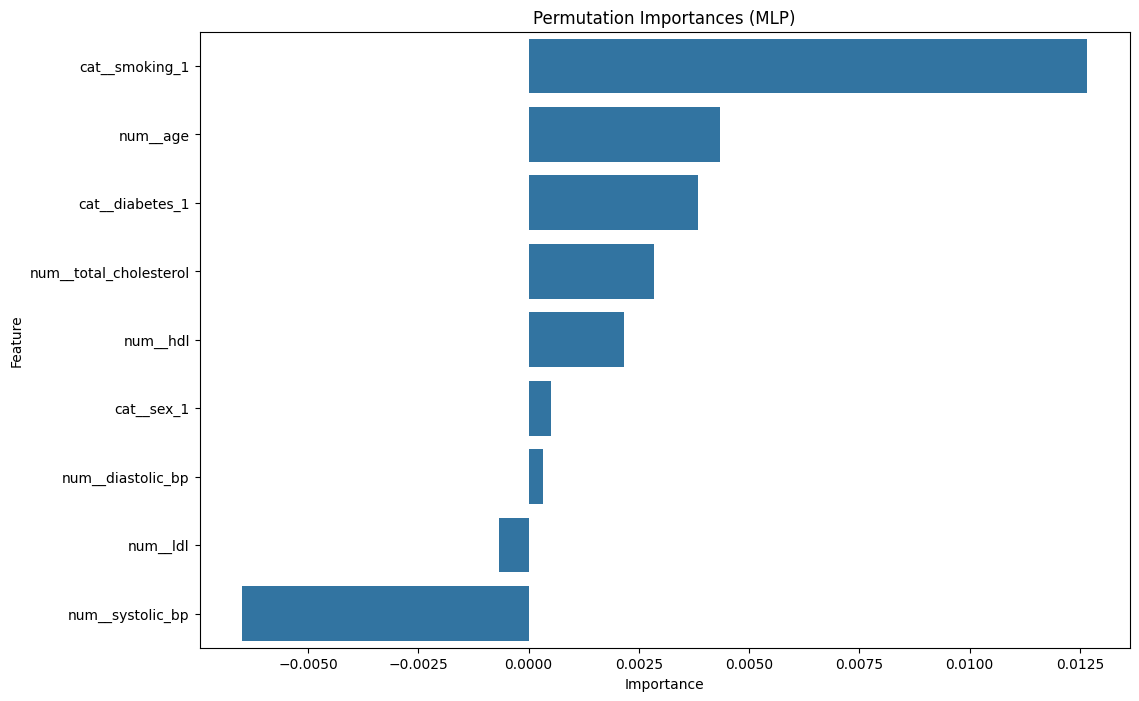


Sobol Indices for MLP:
                   Feature        S1  S2
8         cat__diabetes_1  0.239313 NaN
7          cat__smoking_1  0.104917 NaN
5       num__diastolic_bp  0.039594 NaN
1  num__total_cholesterol  0.038557 NaN
3                num__hdl  0.018653 NaN
0                num__age  0.012900 NaN
2                num__ldl  0.010470 NaN
4        num__systolic_bp -0.015116 NaN
6              cat__sex_1 -0.033769 NaN


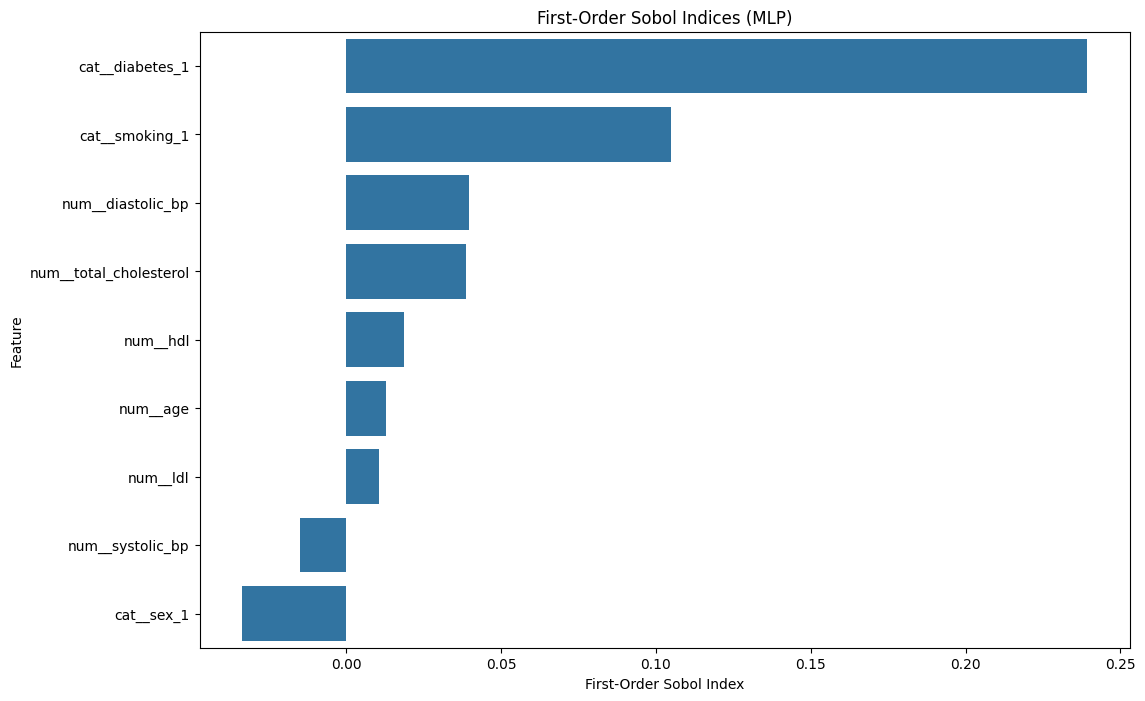

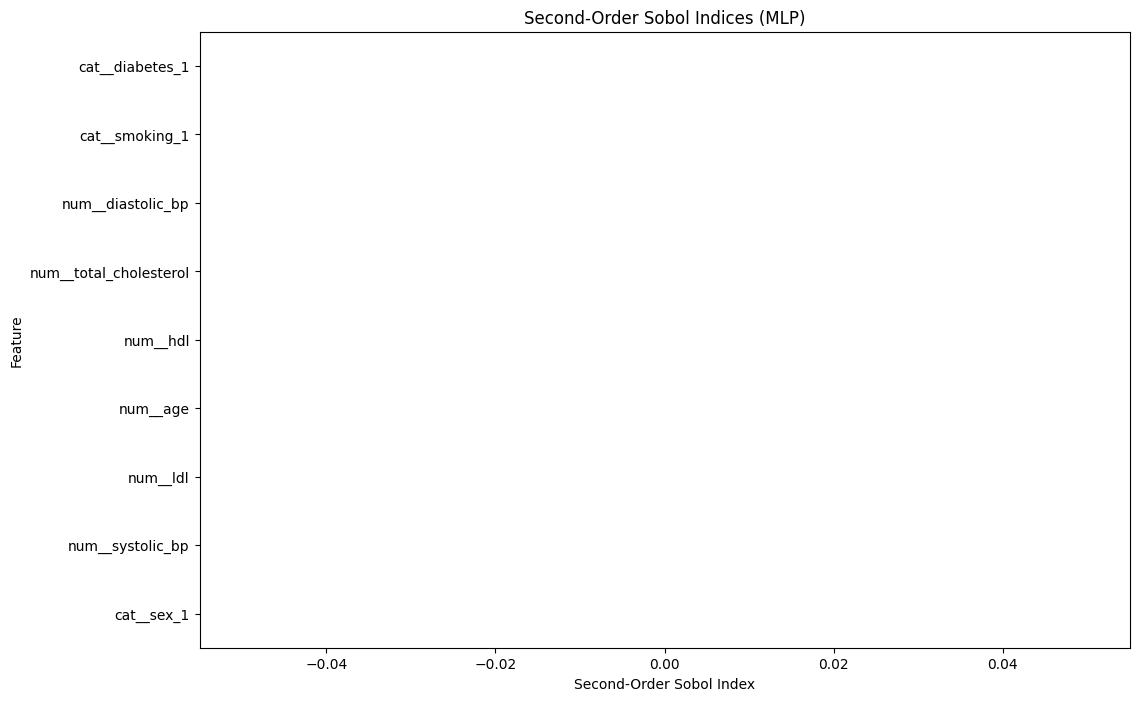

In [8]:
# ### Multi-Layer Perceptron Classifier

# Define the parameter grid for MLP
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (150,), (50, 50), (100, 100)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}
# Initialize the MLP Classifier
mlp_model = MLPClassifier(max_iter=1000, random_state=42)

# Initialize GridSearchCV for MLP
grid_search_mlp = GridSearchCV(estimator=mlp_model, param_grid=param_grid_mlp, cv=3, n_jobs=-1, verbose=2, scoring=scoring, refit='accuracy')

# Fit GridSearchCV for MLP
grid_search_mlp.fit(X_train_preprocessed_df, y_train)

# Best parameters and best score for MLP
best_params_mlp = grid_search_mlp.best_params_
best_score_mlp = grid_search_mlp.best_score_
print(f"Best Parameters for MLP: {best_params_mlp}")
print(f"Best Cross-Validated Accuracy for MLP: {best_score_mlp}")

# Use the best model for MLP
best_mlp_model = grid_search_mlp.best_estimator_

# Make predictions with the best MLP model
y_pred_best_mlp = best_mlp_model.predict(X_test_preprocessed_df)

# Evaluate the best MLP model
accuracy_mlp = accuracy_score(y_test, y_pred_best_mlp)
precision_mlp = precision_score(y_test, y_pred_best_mlp)

recall_mlp = recall_score(y_test, y_pred_best_mlp)
f1_mlp = f1_score(y_test, y_pred_best_mlp)

print(f"Best MLP Accuracy: {accuracy_mlp}")
print(f"Best MLP Precision: {precision_mlp}")
print(f"Best MLP Recall: {recall_mlp}")
print(f"Best MLP F1 Score: {f1_mlp}")

# Perform permutation importance for MLP
perm_importance_mlp = permutation_importance(best_mlp_model, X_test_preprocessed_df, y_test, n_repeats=30, random_state=42, n_jobs=-1)

# Create a DataFrame for permutation importances for MLP
perm_importance_df_mlp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': perm_importance_mlp.importances_mean
})

# Sort the DataFrame by importance for MLP
perm_importance_df_mlp = perm_importance_df_mlp.sort_values(by='Importance', ascending=False)

# Display the permutation importances for MLP
print("\nPermutation Importances for MLP:\n", perm_importance_df_mlp)

# Plot permutation importances for MLP
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=perm_importance_df_mlp)
plt.title('Permutation Importances (MLP)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# ### Sobol Sensitivity Analysis for MLP

# Predict using the trained MLP model
Y_mlp = best_mlp_model.predict(param_values)

# Perform Sobol Sensitivity Analysis for MLP
Si_mlp = sobol.analyze(problem, Y_mlp, print_to_console=False)

# Create a DataFrame for Sobol indices for MLP
sobol_indices_df_mlp = pd.DataFrame({
    'Feature': feature_names,
    'S1': Si_mlp['S1'],
    'S2': Si_mlp['S2'].mean(axis=1)  # Average of second-order indices
})

# Sort the DataFrame by first-order indices for MLP
sobol_indices_df_mlp = sobol_indices_df_mlp.sort_values(by='S1', ascending=False)

# Display the Sobol indices for MLP
print("\nSobol Indices for MLP:\n", sobol_indices_df_mlp)

# Plot first-order Sobol indices for MLP
plt.figure(figsize=(12, 8))
sns.barplot(x='S1', y='Feature', data=sobol_indices_df_mlp)
plt.title('First-Order Sobol Indices (MLP)')
plt.xlabel('First-Order Sobol Index')
plt.ylabel('Feature')
plt.show()

# Plot second-order Sobol indices for MLP
plt.figure(figsize=(12, 8))
sns.barplot(x='S2', y='Feature', data=sobol_indices_df_mlp)
plt.title('Second-Order Sobol Indices (MLP)')
plt.xlabel('Second-Order Sobol Index')
plt.ylabel('Feature')
plt.show()

In [9]:
# Save the preprocessor
joblib.dump(preprocessor, 'preprocessor.pkl')

# Save the models
joblib.dump(best_rf_model, 'best_rf_model.pkl')
joblib.dump(best_lr_model, 'best_lr_model.pkl')
joblib.dump(best_mlp_model, 'best_mlp_model.pkl')

['best_mlp_model.pkl']